# Text Classification Using Word Embeddings

In this notebook, we'll use **pre trained word embeddings** to classify text.
#### Word Embeddings - from GloVe

"Word embeddings" are a family of natural language processing techniques aiming at mapping semantic meaning into a geometric space. This is done by associating a numeric vector to every word in a dictionary, such that the distance (e.g. L2 distance or more commonly cosine distance) between any two vectors would capture part of the semantic relationship between the two associated words. The geometric space formed by these vectors is called an embedding space.

The embeddings themselves can be visualized by a method known at t-SNE. More on t-SNE here: [link]

- http://nlp.stanford.edu/projects/glove/
- GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics.
- Specifically, we will use the 100-dimensional GloVe embeddings of 400k words computed on a 2014 dump of English Wikipedia. You can download them here (warning: following this link will start a 822MB download).


#### Dataset: 20 Newsgroup CMU dataset

- http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
- Has 20 news groups (topics), each with XYZ files

#### Approach

Here's how to solve the text classification problem.

- convert all text samples in the dataset to sequences of word indices. A **word index** is simply an integer ID for a given word. We only consider the top 20,000 most commonly occuring words in the dataset, and will truncate the sequences to a max len of 1000 words.
- prepare an **embedding matrix**, which has at index i the **embedding vector** for the word at index i
- load this embedding matrix into a Keras `Embedding` layer, and _freeze_ it (i.e. its weights, embdeeing vectors will not update during training)
- build on top of it a **1D convolutional net** ending with a _softmax_ output over the 20 news categories


#### Acknowledgments:

* This notebook is based on Keras blog post: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html



In [5]:
from __future__ import print_function
import os
import numpy as np
np.random.seed(1337)

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
%load_ext watermark

In [6]:
## Watermark
%watermark -a 'Atul Acharya' -u -d -v -p numpy,tensorflow,matplotlib,keras

Atul Acharya 
last updated: 2016-12-05 

CPython 3.5.2
IPython 5.0.0

numpy 1.11.2
tensorflow 0.11.0rc2
matplotlib 1.5.1
keras 1.1.0


In [7]:
## Some useful defs

In [3]:
DATASET_DIR = '/Users/aa/Developer/datasets'
GLOVE_DIR = DATASET_DIR + '/glove-word-embeddings/'   # Word embeddings dataset
TEXT_DATA_DIR = DATASET_DIR + '/20_newsgroup/'        # 20 Newsgroup dataset

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
import sys


#### 1 - Build index mapping: Embedding Layer
- map words to their embedding vectors

In [9]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS  = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [10]:
print('Indexing word vectors')

embeddings_index = {}

with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word   = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs
        
print('Found %s word vectors' % len(embeddings_index))


Indexing word vectors
Found 400000 word vectors


In [28]:
# show some embeddings
k = 0
for em, i in embeddings_index.items():
    if k < 5:
        print(em, i)
        k += 1


60,000-plus [ 0.11497     0.13181999 -0.036295    0.37399    -0.19670001  0.11394
 -0.15239     0.12558     0.23926     0.22567999  0.094026    0.14103
 -0.035312   -0.56836998 -0.11998    -0.25628999 -0.35617     0.18084
  0.38212001 -0.22699    -0.15306    -0.20634    -0.38174999 -0.40114
 -0.23476    -0.27184999  0.02555     0.18644001  0.058272   -0.44304001
  0.52873999 -0.24343     0.24151    -0.082683    0.01956     0.10489
 -0.14467999 -0.28066     0.15166     0.18826     0.63266999 -0.024391
  0.053273    0.11065    -0.0081538   0.20677    -0.08977     0.032328
  0.33017001  0.31505001  0.20499    -0.43628001 -0.20284    -0.56557
  0.030779    0.60136002  0.22443999 -0.19825999  0.016973   -0.85674
  0.18603    -0.36919001  0.34057    -0.19108    -0.46323001 -0.077863
 -0.39388001 -0.26210001 -0.026738   -0.1455      0.3549      0.39835
  0.029413    0.25602999 -0.25029999  0.081387   -0.18223    -0.23507001
  0.28896999  0.375      -0.22283     0.068424    0.59353    -0.57740

#### 2 - Prepare the text data

- Iterate over the folders in News dataset, and format them into a list of samples
- Prepare a list of class indices matching the samples


In [11]:
print ('Processing text dataset')

texts  = []  # list of text samples
labels = []  # list of label IDs
labels_index = {}   # dict mapping label name --> numeric ID

for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    
    # for each dir
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        
        # for each file in dir
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                
                # read the file, save it
                texts.append(f.read())
                f.close()
                
                # save label ID
                labels.append(label_id)

print('Found %s texts' % len(texts))

Processing text dataset
Found 19997 texts


#### 3 - Vectorize the text samples

Use `keras.preprocessing.text.Tokenizer` and `keras.preprocessing.sequence.pad_sequences` to format the text samples and labels into tensors for feeding the conv net.

In [12]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# word index
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# convert labels to 1-hot encoding vector
labels = to_categorical(np.asarray(labels))

print('Data tensor: ', data.shape)
print('Label tensor:', labels.shape)

Found 214873 unique tokens
Data tensor:  (19997, 1000)
Label tensor: (19997, 20)


In [30]:
# debug - show word_index
m = 0
for k,v in word_index.items():
    if m < 5:
        print(k, v)
        m += 1

f446 108722
untitled 77067
shunts 108723
troubling 22521
snk40uk 108725


In [13]:
### Split data into Training / Validation
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data   = data[indices]
labels = labels[indices]

nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
print('nb_validation', nb_validation_samples)

x_train  = data[:-nb_validation_samples]
y_train  = labels[:-nb_validation_samples]

x_val    = data[-nb_validation_samples:]
y_val    = labels[-nb_validation_samples:]

print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('x_val shape', x_val.shape)
print('y_val shape', y_val.shape)

nb_validation 3999
x_train shape (15998, 1000)
y_train shape (15998, 20)
x_val shape (3999, 1000)
y_val shape (3999, 20)


#### 4 - Prepare Embedding Matrix

- leverage our `embedding_index` dictionary and our `word_index` to compute our embedding matrix
- load this `embedding matrix` into an `Embedding` layer. Note that we set trainable=False to prevent the weights from being updated during training.

An Embedding layer should be fed sequences of integers, i.e. a 2D input of shape `(samples, indices)`. These input sequences should be padded so that they all have the same length in a batch of input data (although an Embedding layer is capable of processing sequence of heterogenous length, if you don't pass an explicit input_length argument to the layer).

All that the Embedding layer does is to **map the integer inputs to the vectors found at the corresponding index** in the _embedding matrix_, i.e. the sequence `[1, 2]` would be converted to `[embeddings[1], embeddings[2]]`. This means that the output of the Embedding layer will be a 3D tensor of shape `(samples, sequence_length, embedding_dim)`.

In [15]:
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros( (nb_words +1, EMBEDDING_DIM) )

for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
        
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

# Now load pre-trained word embeddings into Embedding layer
# NOTE: set trainable=False to freeze the layer (i.e. no weight update)

embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,     # this was 100 above
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Embedding layer:', embedding_layer)

Embedding layer: <keras.layers.embeddings.Embedding object at 0x14b400f28>


In [24]:
embedding_layer.name
print('Embedding matrix', embedding_matrix.shape)
embedding_layer.output_dim

Embedding matrix (20001, 100)


100

### 5 - Train a 1D convolutional net

Build a small 1D conv net 

In [31]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

embedded_sequences = embedding_layer(sequence_input)

# 1D conv net
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
# flatten
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# now output predictions
predictions = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, predictions)
# print
model.summary()

## Compile the model
model.compile(loss='categorical_crossentropy',   # bcos we have 20 classes
             optimizer='rmsprop',
             metrics=['acc'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1000, 100)     0           input_1[0][0]                    
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 996, 128)      64128       embedding_1[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 199, 128)      0           convolution1d_1[0][0]            
___________________________________________________________________________________________

In [32]:
### Train the model

history = model.fit(x_train,
                   y_train,
                   validation_data=(x_val, y_val),
                   nb_epoch=2,
                   batch_size=128)

Train on 15998 samples, validate on 3999 samples
Epoch 1/2
15998/15998 [==============================] - 251s - loss: 2.1205 - acc: 0.2822 - val_loss: 0.9944 - val_acc: 0.6157
Epoch 2/2
15998/15998 [==============================] - 244s - loss: 0.4882 - acc: 0.8311 - val_loss: 0.1853 - val_acc: 0.9375


In [33]:
## Plot
def plot_accuracy(history, model_name='model', y1='acc', y2='val_acc'):
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' accuracy')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

def plot_loss(history, model_name='model', y1='loss', y2='val_loss'):
    plt.plot(history.history[y1])
    plt.plot(history.history[y2])
    plt.title(model_name + ' loss')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

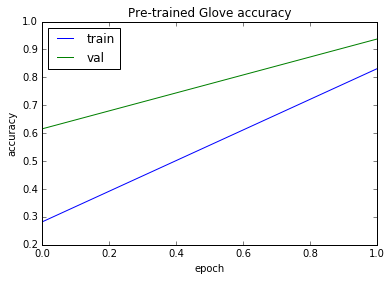

In [34]:
plot_accuracy(history, model_name='Pre-trained Glove')

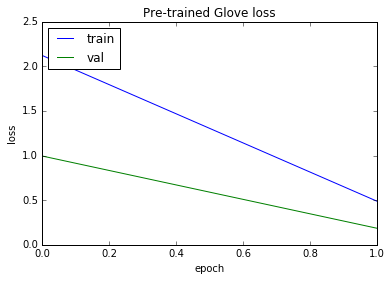

In [35]:
plot_loss(history, model_name='Pre-trained Glove')

We ar able to achieve **~93% validation accuracy** with the pre-trained GloVe word embeddings. Without the pre-trained weights, we would get roughly 85%-90% accuracy.